In [1]:
""" 
IMPORTS
"""
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.stats import zscore

from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from one.api import ONE
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs
functions_path =  prefix + '/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
# from plotting_functions import plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import keypoint_speed_one_camera
one = ONE(mode='remote')

In [2]:
import jax
# import jaxlib
# print(jaxlib.__version__)
jax.devices()

[CpuDevice(id=0)]

# Parameters

In [41]:
bin_size = 0.017
num_train_batches = 5
num_states = 2
method ='prior'
num_lags = 10
kappa = 0
zsc = False

## Get data

In [5]:
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/'+str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

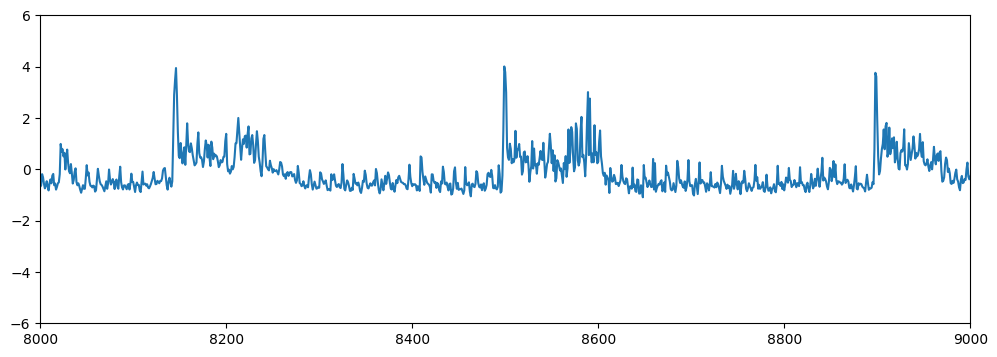

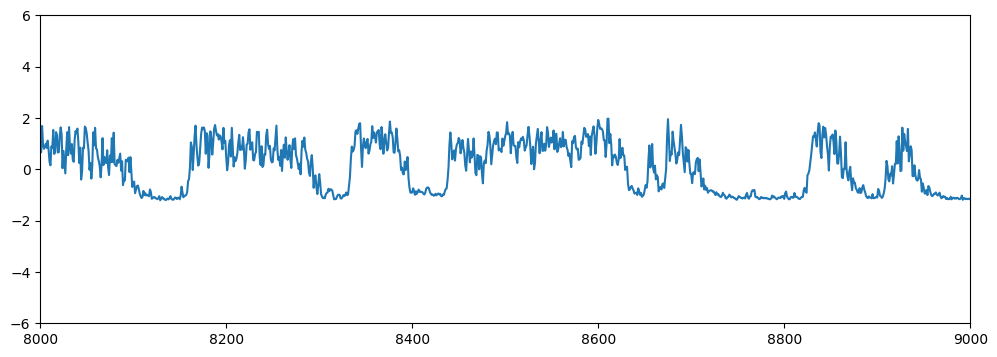

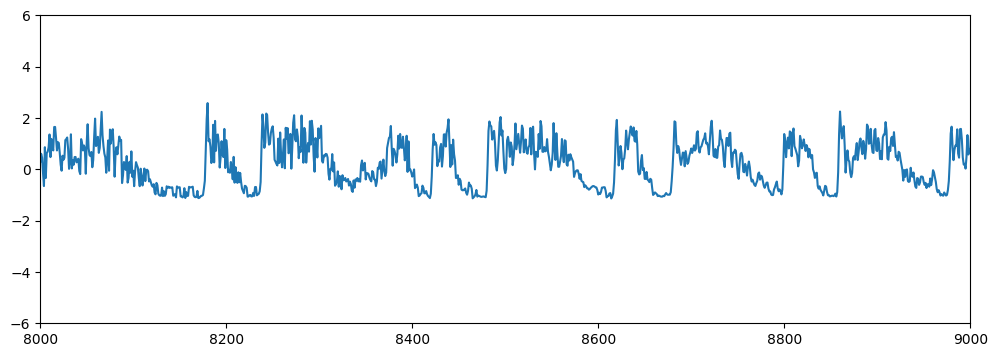

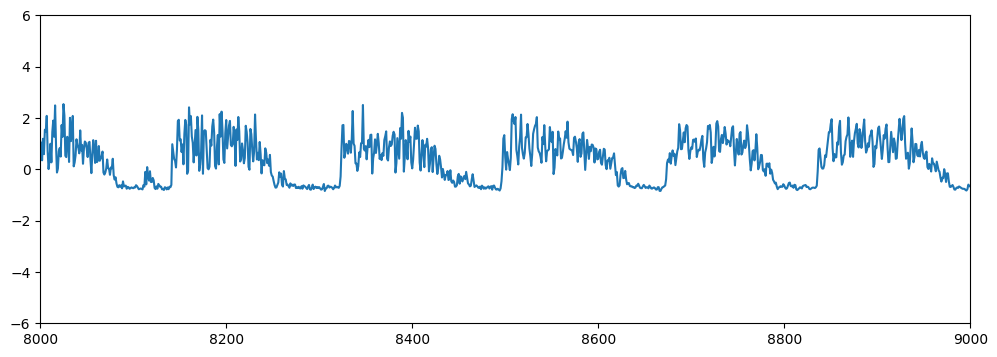

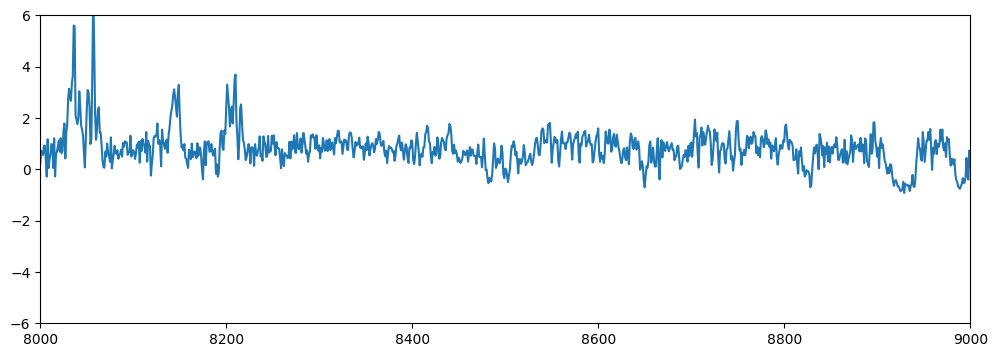

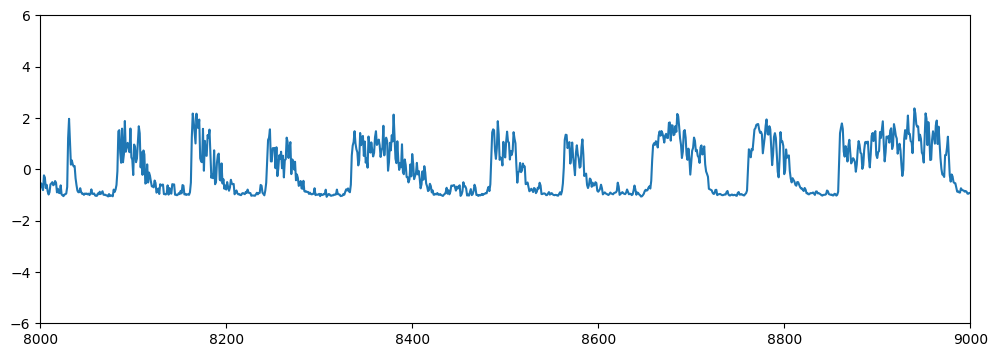

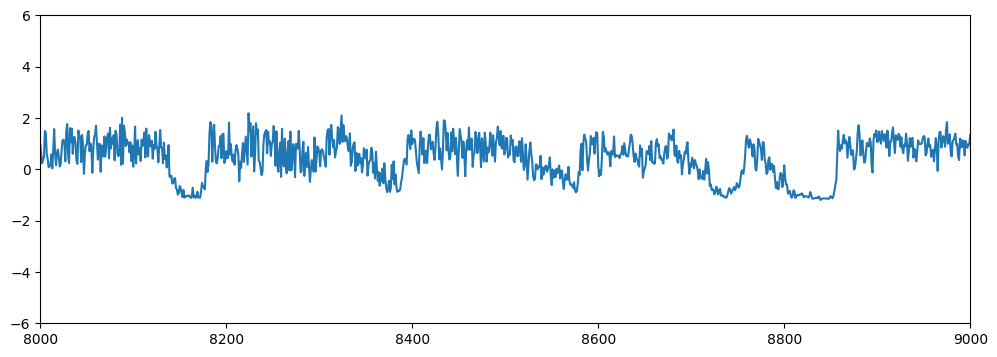

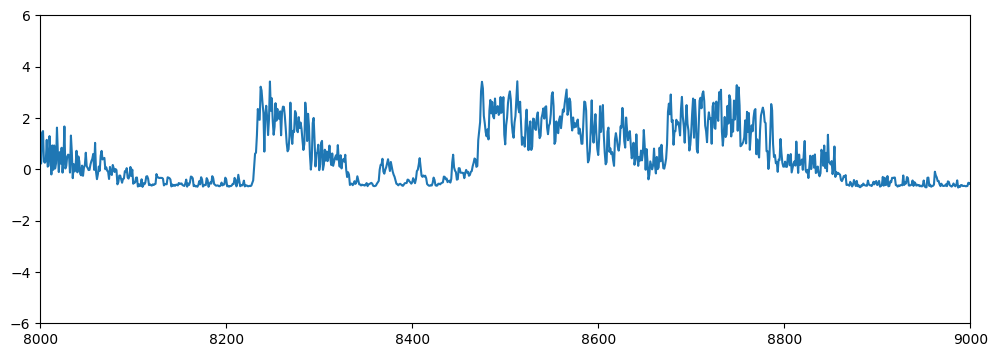

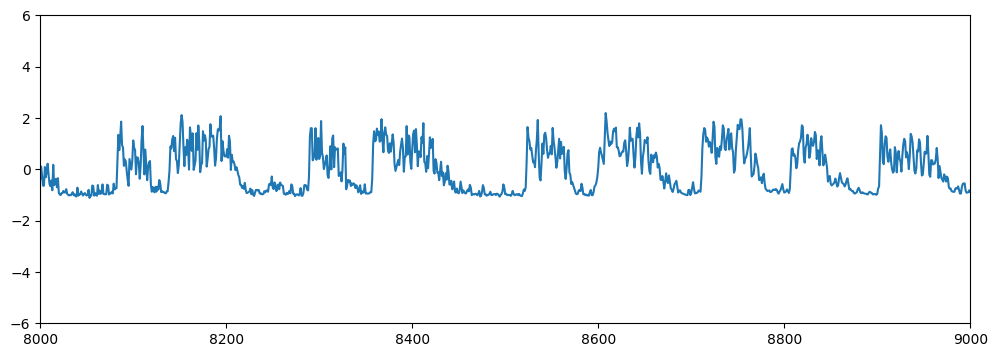

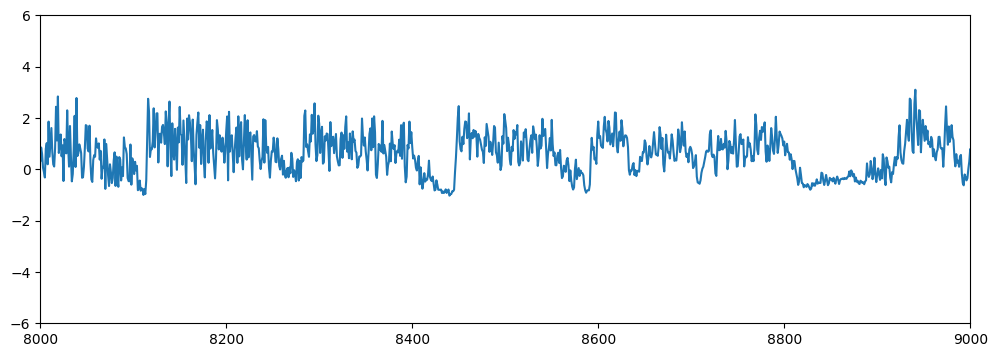

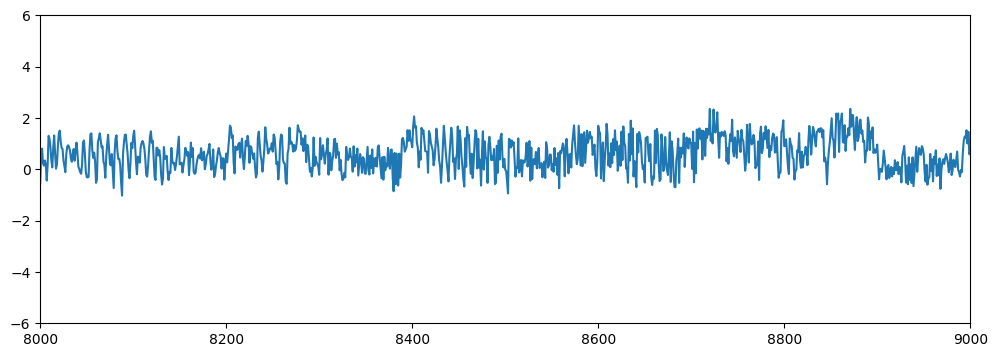

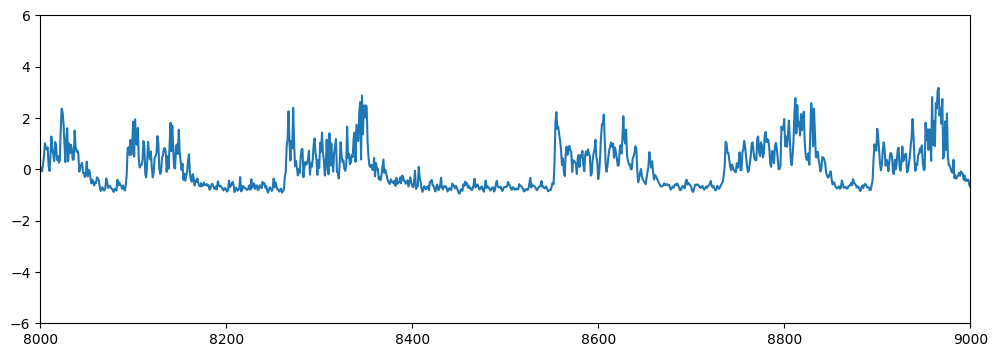

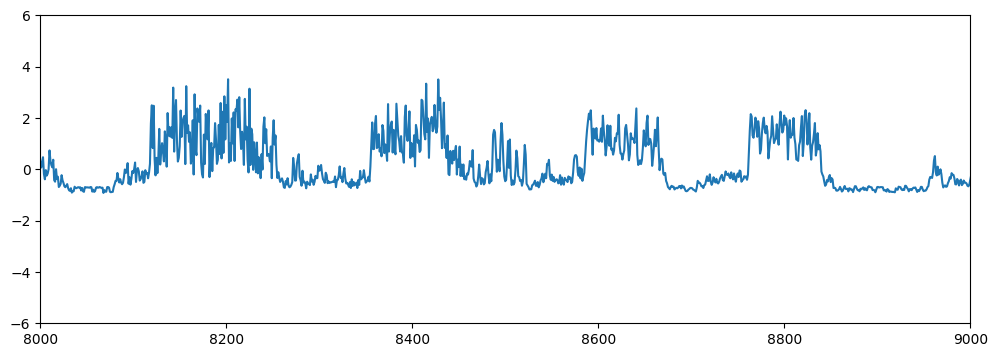

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/v6_21Jul2025/0.017/standardized_design_matrix_a9138924-4395-4981-83d1-530f6ff7c8fc_ibl_witten_26.npy'

In [6]:
variables_to_fit = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
variables_to_fit = ['l_paw_x', 'l_paw_y']
variables_to_fit = ['whisker_me']
# variables_to_fit = ['avg_wheel_vel']

for m, mat in enumerate(idxs):
      mouse_name = mat[37:]
      session = mat[:36]

      # Load mouse/session data
      filename = "design_matrix_" + str(session) + '_'  + mouse_name
      original_design_matrix = pd.read_parquet(data_path + filename)
      filename = "standardized_design_matrix_" + str(session) + '_'  + mouse_name
      standardized_designmatrix = np.load(data_path + filename+str('.npy'))

      # Need to dropnans
      if zsc == True:
              array_matrix = zscore(np.array(original_design_matrix), axis=0, nan_policy='omit')
      else:
              array_matrix = np.array(original_design_matrix)
              
      # filtered_matrix = np.abs(standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)])
      filtered_matrix = array_matrix[~np.isnan(array_matrix).any(axis=1)]
#       if variables_to_fit == ['avg_wheel_vel']:
#               filtered_matrix = np.abs(array_matrix[~np.isnan(array_matrix).any(axis=1)])
      keys = np.where(original_design_matrix.keys().isin(variables_to_fit))
      design_matrix = filtered_matrix[:, keys]
      design_matrix = np.reshape(design_matrix,(np.shape(design_matrix)[0], np.shape(design_matrix)[2]))

      " Plots "
      fig, ax = plt.subplots(figsize=(12, 4))
      states_to_append =np.arange(0, num_states, 1)
      plot_max = 500
      plot_min = -500

      plt.plot(np.array(design_matrix[:, 0]))
      plt.xlim([8000,9000])
      plt.ylim([-6, 6])
      plt.show()

Fitting session NR_0027ae8787b1-4229-4d56-b0c2-566b61a25b77...


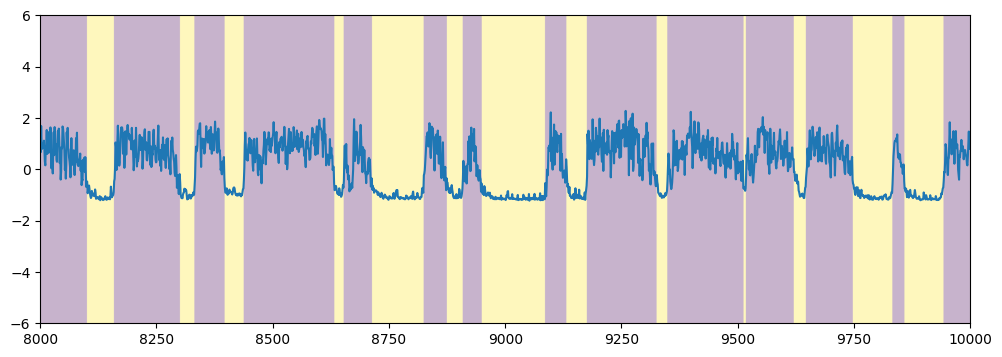

In [42]:
variables_to_fit = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
variables_to_fit = ['l_paw_x', 'l_paw_y']
variables_to_fit = ['r_paw_x', 'r_paw_y']
variables_to_fit = ['whisker_me']
# variables_to_fit = ['avg_wheel_vel']

for m, mat in enumerate(idxs[1:2]):
      mouse_name = mat[37:]
      session = mat[:36]

      # Load mouse/session data
      filename = "design_matrix_" + str(session) + '_'  + mouse_name
      original_design_matrix = pd.read_parquet(data_path + filename)
      filename = "standardized_design_matrix_" + str(session) + '_'  + mouse_name
      standardized_designmatrix = np.load(data_path + filename+str('.npy'))

      # Need to dropnans
      if zsc == True:
              array_matrix = zscore(np.array(original_design_matrix), axis=0, nan_policy='omit')
      else:
              array_matrix = np.array(original_design_matrix)
              
      # filtered_matrix = np.abs(standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)])
      filtered_matrix = array_matrix[~np.isnan(array_matrix).any(axis=1)]  # [:100000] # [:50000]
#       if variables_to_fit == ['avg_wheel_vel']:
#               filtered_matrix = np.abs(array_matrix[~np.isnan(array_matrix).any(axis=1)])
      keys = np.where(original_design_matrix.keys().isin(variables_to_fit))
      design_matrix = filtered_matrix[:, keys]
      design_matrix = np.reshape(design_matrix,(np.shape(design_matrix)[0], np.shape(design_matrix)[2]))
      fit_id = str(mouse_name + session)
      print(f"Fitting session {fit_id}...")

      # Prepare data format
      num_timesteps = np.shape(design_matrix)[0]
      emission_dim = np.shape(design_matrix)[1]
      shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
      train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

      test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
      # Compute inputs for required timelags
      my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
      train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

      all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0),
                                          train_emissions, train_inputs, method, num_train_batches, 'em')

      use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
      # Find parameters for best fold
      initial_probs = fit_params[0].probs[use_fold]
      transition_matrix = fit_params[1].transition_matrix[use_fold]
      emission_weights = fit_params[2].weights[use_fold]
      emission_biases = fit_params[2].biases[use_fold]
      emission_covariances = fit_params[2].covs[use_fold]

      # Initialize new hmm
      new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
      best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                      initial_probs=initial_probs,
                                      transition_matrix=transition_matrix,
                                      emission_weights=emission_weights,
                                      emission_biases=emission_biases,
                                      emission_covariances=emission_covariances,
                                      emissions=shortened_array)  # not sure if I need to include

      # Get state estimates for validation data
      most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

      # Remove states below threshold
      new_states = np.array(most_likely_states).astype(float)
      new_states = most_likely_states

      " Plots "
      fig, ax = plt.subplots(figsize=(12, 4))
      states_to_append =np.arange(0, num_states, 1)
      plot_max = 500
      plot_min = -500

      plt.plot(np.array(design_matrix[:, 0]))
#       plt.plot(np.array(design_matrix[:, 1]))
      # plt.plot(np.array(design_matrix[:, 2]))
      # plt.plot(np.array(design_matrix[:, 3]))

      plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:],
              extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
              aspect="auto",
              cmap='viridis',
              alpha=0.3)
      plt.xlim([8000,10000])
      plt.ylim([-6, 6])
      plt.show()

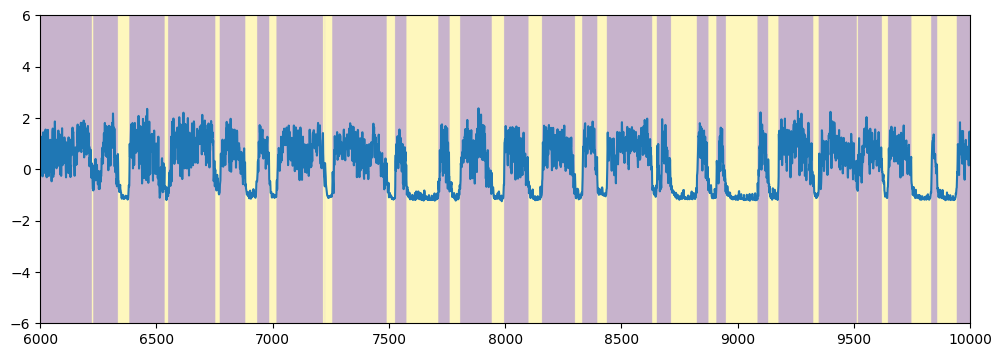

In [48]:
      fig, ax = plt.subplots(figsize=(12, 4))
      states_to_append =np.arange(0, num_states, 1)
      plot_max = 500
      plot_min = -500

      plt.plot(np.array(design_matrix[:, 0]))
#       plt.plot(np.array(design_matrix[:, 1]))
      # plt.plot(np.array(design_matrix[:, 2]))
      # plt.plot(np.array(design_matrix[:, 3]))

      plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:],
              extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
              aspect="auto",
              cmap='viridis',
              alpha=0.3)
      plt.xlim([6000,10000])
      plt.ylim([-6, 6])
      plt.show()

In [85]:
split = True
ephys = True
session = 'fbd28ea6-3251-48e0-b215-2c51ec5185f7'

# l_paw_speed = keypoint_speed_one_camera(one, session, ephys, 'left', 'paw_l', split, True)
# r_paw_speed = keypoint_speed_one_camera(one, session, ephys, 'left', 'paw_r', split, True)

l_paw_speed = keypoint_speed_one_camera(one, session, ephys, 'right', 'paw_l', split, True)
r_paw_speed = keypoint_speed_one_camera(one, session, ephys, 'right', 'paw_r', split, True)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2024-05-06", "2025-06-02", "2025-05-31", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2024-05-06", "2025-06-02", "2025-05-31", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2024-05-06", "2025-06-02", "2025-05-31", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-06-18", "2025-03-03", "2024-05-06", "2025-06-02", "2025-05-31", "2025-06-01

(-500.0, 500.0)

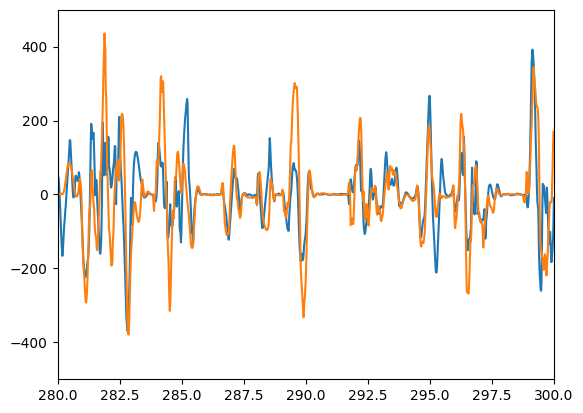

In [10]:
plt.plot(l_paw_speed['left'][0][:-1], l_paw_speed['left'][1])
# plt.plot(l_paw_speed['left'][0][:-1], l_paw_speed['left'][2])

plt.plot(r_paw_speed['left'][0][:-1], r_paw_speed['left'][1])
# plt.plot(r_paw_speed['right'][0][:-1], r_paw_speed['right'][2])
plt.xlim([280, 300])
plt.ylim([-500, 500])


In [ ]:
# Use reference time, truncate and resample
onset = np.max([np.min(me_time), np.min(t_common), np.min(wheel_time)])
offset = np.min([np.max(me_time), np.max(t_common), np.max(wheel_time)])

common_fs = 60
# Set common sampling rate (high rather than low)
reference_time = np.arange(onset, offset, 1/common_fs)  # uniform timestamps

motion_energy = motion_energy[np.where((me_time >= onset) & (me_time <= offset))[0]]
me_time = me_time[np.where((me_time >= onset) & (me_time <= offset))[0]]
donwsampled_me, corrected_me_t = resample_common_time(reference_time, me_time, motion_energy, kind='linear', fill_gaps=None)

## Parameters

In [80]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
num_states = 2
num_lags = 1 # First order ARHMM
kappa = 100

In [86]:
# Prepare data format
design_matrix = np.array(l_paw_speed['right'][1:]).T
design_matrix = design_matrix[~np.isnan(design_matrix).any(axis=1), :]
num_timesteps = np.shape(design_matrix)[0]
emission_dim = np.shape(design_matrix)[1]
shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    
test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
# Compute inputs for required timelags
my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

# all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
#                                     train_emissions, train_inputs, method, num_train_batches)
all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), 
                                    train_emissions, train_inputs, method, num_train_batches, 'em')

use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
# Find parameters for best fold
initial_probs = fit_params[0].probs[use_fold]
transition_matrix = fit_params[1].transition_matrix[use_fold]
emission_weights = fit_params[2].weights[use_fold]
emission_biases = fit_params[2].biases[use_fold]
emission_covariances = fit_params[2].covs[use_fold]        
            
# Initialize new hmm
new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                initial_probs=initial_probs,
                                transition_matrix=transition_matrix,               
                                emission_weights=emission_weights,
                                emission_biases=emission_biases, 
                                emission_covariances=emission_covariances,
                                emissions=shortened_array)  # not sure if I need to include  

# Get state estimates for validation data
most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
        
# Remove states below threshold
new_states = np.array(most_likely_states).astype(float)
new_states = most_likely_states



(3000.0, 9000.0)

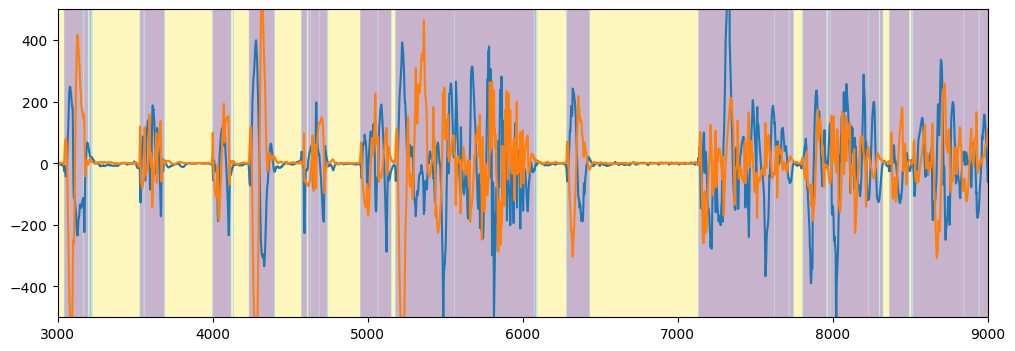

In [90]:
" Plots "
fig, ax = plt.subplots(figsize=(12, 4))
# for v, var in enumerate(var_names):
#     plt.plot(np.array(unnorm_mat[var]))
states_to_append =np.arange(0, num_states, 1)
plot_max = 500
plot_min = -500

plt.plot(np.array(design_matrix[:, 0]))
plt.plot(np.array(design_matrix[:, 1]))

plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:], 
        extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
        aspect="auto",
        cmap='viridis',
        alpha=0.3) 
plt.xlim([3000,9000])


In [12]:
l_paw_speed

{'left': [array([ 135.13335198,  135.15001698,  135.16668198, ..., 4529.61782625,
         4529.63449125, 4529.65112292]),
  array([ 16.52163489,  13.56288126,  10.83165175, ...,  -9.88843527,
         -11.29453996, -12.78883585]),
  array([12.56879005, 10.81446431,  9.15652378, ..., -0.91454133,
         -0.58332145, -0.18123746])]}

# Fit best params on individual sessions

/tmp/ipykernel_385174/2371556809.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']


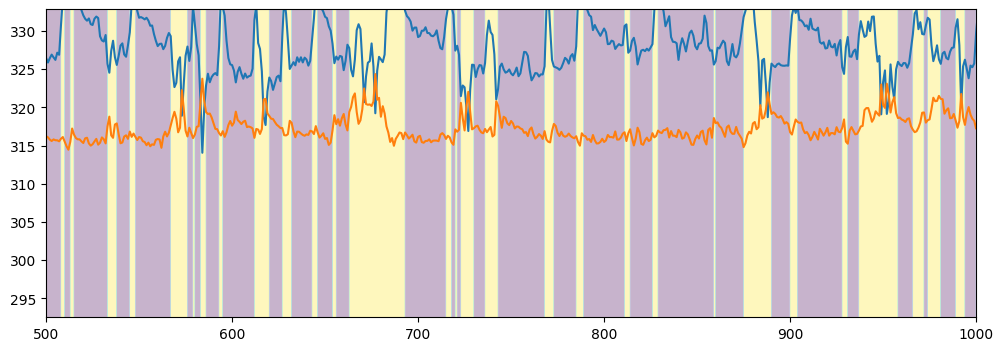

In [8]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(idxs[0:1]): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'ZM_3003'
        session = mat[0:36]
        # session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'

        # Get mouse data
        session_trials = session_all[mouse_name][session].reset_index()
        design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
        unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
        unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
        
        # # Remove parts where wheel is not moving
        # unnorm_mat = remove_wheel_quiescence(unnorm_mat, extended, mouse_name, session)
        # design_matrix = np.array(unnorm_mat['avg_wheel_vel']).reshape(-1, 1)
        
        # Prepare data format
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
    
        all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                            train_emissions, train_inputs, method, num_train_batches)
        
        use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
            
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
        
        # Keep only enough states to explain 95% observations
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan
        
        
        new_states = most_likely_states
        
        " Plots "
        fig, ax = plt.subplots(figsize=(12, 4))
        for v, var in enumerate(var_names):
            plt.plot(np.array(unnorm_mat[var]))
            states_to_append =np.arange(0, num_states, 1)
            plot_max = np.max(np.array(unnorm_mat[var]))
            plot_min = np.min(np.array(unnorm_mat[var]))

        plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
        plt.xlim([500,1000])
        
        
        # """ Plot raw traces over states """
        # init = 250*multiplier # First bin
        # inter = 20*multiplier
        # # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        # traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)



# Fit without wheel stillness

In [5]:
def remove_wheel_quiescence(unnorm_mat, extended, mouse_name, session):
    
    wheel_on = extended.loc[(extended['mouse_name']==mouse_name)&(extended['session']==session)]
    wheel_on['bin_0.1'] = wheel_on['Bin']
    wheel_on = wheel_on[['wheel_on', 'bin_0.1']]
    new_mat = unnorm_mat.copy()
    new_mat['bin_0.1'] = np.round(new_mat['Bin']*bin_size/0.1)
    joint = wheel_on.merge(new_mat, on=['bin_0.1'])
    new_unnorm_mat = joint.loc[joint['wheel_on']==1.0][['Bin', 'avg_wheel_vel']]
    
    return new_unnorm_mat


In [7]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(idxs[0:1]): #
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        mouse_name = 'ZM_3003'
        session = mat[0:36]
        session = '934dd7a4-fbdc-459c-8830-04fe9033bc28'

        # Get mouse data
        session_trials = session_all[mouse_name][session].reset_index()
        design_matrix = matrix_all[mouse_name][session][:,idx_init:idx_end]
        unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
        unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']
        
        # Remove parts where wheel is not moving
        unnorm_mat = remove_wheel_quiescence(unnorm_mat, extended, mouse_name, session)
        design_matrix = np.array(unnorm_mat['avg_wheel_vel']).reshape(-1, 1)
        
        # Prepare data format
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
    
        all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                            train_emissions, train_inputs, method, num_train_batches)
        
        use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
            
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  
        
        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
        
        # Keep only enough states to explain 95% observations
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan
        
        
        new_states = most_likely_states
        
        " Plots "
        plt.plot(np.array(unnorm_mat.avg_wheel_vel))
        states_to_append =np.arange(0, num_states, 1)
        plot_max = np.max(np.array(unnorm_mat.avg_wheel_vel))
        plot_min = np.min(np.array(unnorm_mat.avg_wheel_vel))

        plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
        plt.xlim([0,500])






/tmp/ipykernel_1330828/210592243.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']


NameError: name 'remove_wheel_quiescence' is not defined

(500.0, 1000.0)

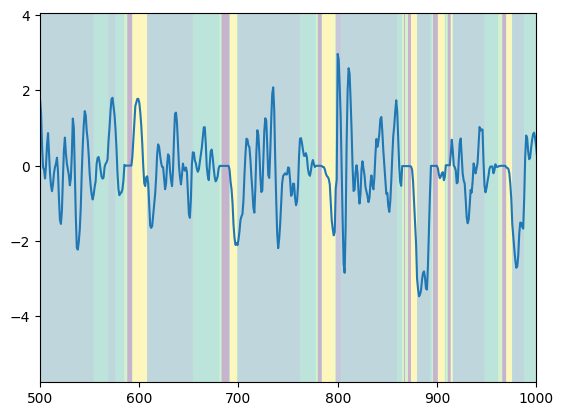

In [9]:
plt.plot(np.array(unnorm_mat.avg_wheel_vel))
states_to_append =np.arange(0, num_states, 1)
plot_max = np.max(np.array(unnorm_mat.avg_wheel_vel))
plot_min = np.min(np.array(unnorm_mat.avg_wheel_vel))

plt.imshow(np.concatenate([most_likely_states, states_to_append])[None,:], 
        extent=(0, len(np.concatenate([most_likely_states, states_to_append])), plot_min, plot_max),
        aspect="auto",
        cmap='viridis',
        alpha=0.3) 
plt.xlim([500,1000])


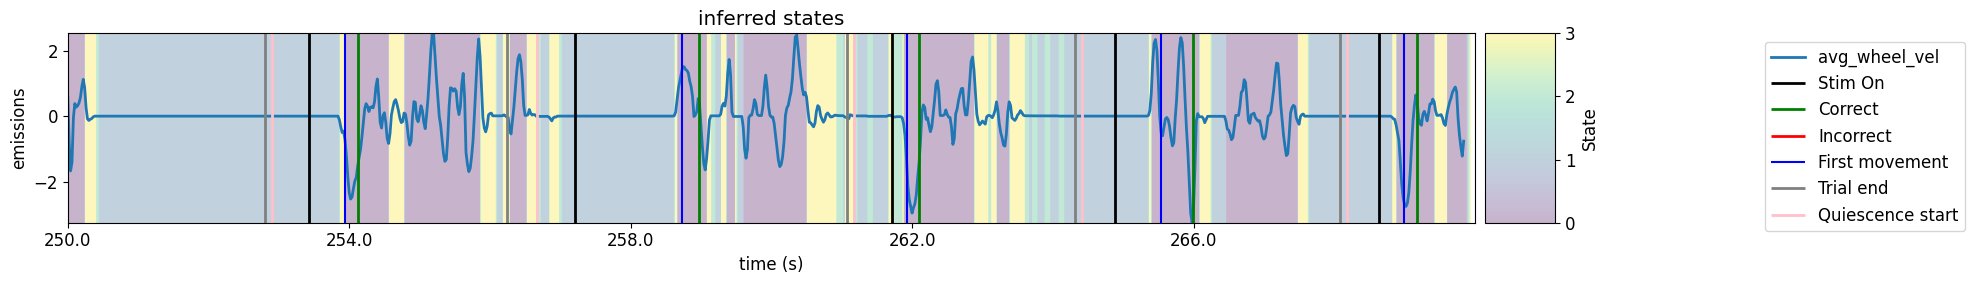

In [83]:

""" Plot raw traces over states """
init = 250*multiplier # First bin
inter = 20*multiplier
# traces_over_few_sates(init, empirical_data, session_trials, var_names)
traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)

In [8]:
        # Keep only enough states to explain 95% observations
        unique, counts = np.unique(most_likely_states, return_counts=True)
        threshold_count = threshold * len(most_likely_states)
        excluded_bins = 0
        remaining_states = list(counts.copy())
        for state in unique:
            size_smallest_state = np.nanmin(remaining_states)
            if size_smallest_state + excluded_bins < threshold_count:
                remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                excluded_bins += size_smallest_state
        
        # Remove states below threshold
        new_states = np.array(most_likely_states).astype(float)
        exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
        # Create a boolean mask to identify values to replace
        mask = np.isin(new_states, exclude_states)
        # Replace values in main_array with np.nan using the boolean mask
        new_states[mask] = np.nan
        
        
        new_states = most_likely_states
        
        " Plots "
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        
        # Fix discontinuities
        cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
        
        # Align bins
        init = -1 * multiplier
        end = 1.5 * multiplier
        empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


        print(mouse_name)
        """ Stack trial states """
        trial_init = 0  # First trial to plot
        trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
        inverted_mapping = []
        plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, inverted_mapping)

        " Plot states stacked and aligned per trial type "
        plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
        # # plt.figure(figsize=[7, 5])
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        
        # plt.title(mouse_name)
        # plt.show()

        """ Plot raw traces over states """
        init = 250*multiplier # First bin
        inter = 20*multiplier
        # traces_over_few_sates(init, empirical_data, session_trials, var_names)
        traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier, inverted_mapping)
                    
        #except:
        #    print(mat + 'not possible')

NameError: name 'most_likely_states' is not defined